# RECOVAR visualization and analysis (copied from cryoDRGN's)

This jupyter notebook provides a template for analyzing results, including:
* plotting of mean, mask and eigenvector
* resolution of mean and decay of eigenvalues
* latent space visualization with PCA/UMAP
* clustering
* trajectories
<!-- * interactive visualization of the latent space, imaging, and pose parameters -->
<!-- * interactive selection of particle images from the latent space -->
<!-- * interactive generation of volumes from the latent space -->

Note that this is a simple template for data analysis, and not a polished UI. Experience with Python/Pandas is recommended.

In [1]:
import recovar.config
from importlib import reload
import numpy as np
from recovar import plot_utils
from recovar import output, dataset
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from recovar import simulator, regularization
reload(simulator)
import jax
import warnings
from recovar.fourier_transform_utils import fourier_transform_utils
import jax.numpy as jnp
ftu = fourier_transform_utils(jnp)


2024-06-18 17:10:45.456952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 17:10:45.457002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 17:10:45.458346: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 17:10:45.465387: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 17:10:47.460797: W tensorflow/compiler/tf2

(INFO) (xla_bridge.py) (18-Jun-24 17:10:52) Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
(INFO) (xla_bridge.py) (18-Jun-24 17:10:52) Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
(INFO) (config.py) (18-Jun-24 17:10:52) Devices found: NVIDIA A100-SXM4-80GB


/home/mg6942/.conda/envs/recovar2/lib/python3.9/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(3, 4, 5, 6, 7, 8), but only accepts 8 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


### Load result from pipeline.py

In [3]:
# Load z
recovar_result_dir = '/scratch/gpfs/mg6942/cryodrgn_empiar/empiar10180/inputs/paper_run/'
pipeline_output = output.PipelineOutput(recovar_result_dir)
cryos = pipeline_output.get('lazy_dataset')

(INFO) (dataset.py) (18-Jun-24 17:12:13) Loading halfset from file
(INFO) (ctf.py) (18-Jun-24 17:12:13) Image size (pix)  : 256
(INFO) (ctf.py) (18-Jun-24 17:12:13) A/pix             : 2.1237499713897705
(INFO) (ctf.py) (18-Jun-24 17:12:13) DefocusU (A)      : 13621.08984375
(INFO) (ctf.py) (18-Jun-24 17:12:13) DefocusV (A)      : 14035.16015625
(INFO) (ctf.py) (18-Jun-24 17:12:13) Dfang (deg)       : 2.4000000953674316
(INFO) (ctf.py) (18-Jun-24 17:12:13) voltage (kV)      : 300.0
(INFO) (ctf.py) (18-Jun-24 17:12:13) cs (mm)           : 2.700000047683716
(INFO) (ctf.py) (18-Jun-24 17:12:13) w                 : 0.10000000149011612
(INFO) (ctf.py) (18-Jun-24 17:12:13) Phase shift (deg) : 0.0
(INFO) (ctf.py) (18-Jun-24 17:12:15) Image size (pix)  : 256
(INFO) (ctf.py) (18-Jun-24 17:12:15) A/pix             : 2.1237499713897705
(INFO) (ctf.py) (18-Jun-24 17:12:15) DefocusU (A)      : 13621.08984375
(INFO) (ctf.py) (18-Jun-24 17:12:15) DefocusV (A)      : 14035.16015625
(INFO) (ctf.py) (18

0.0950470583146632


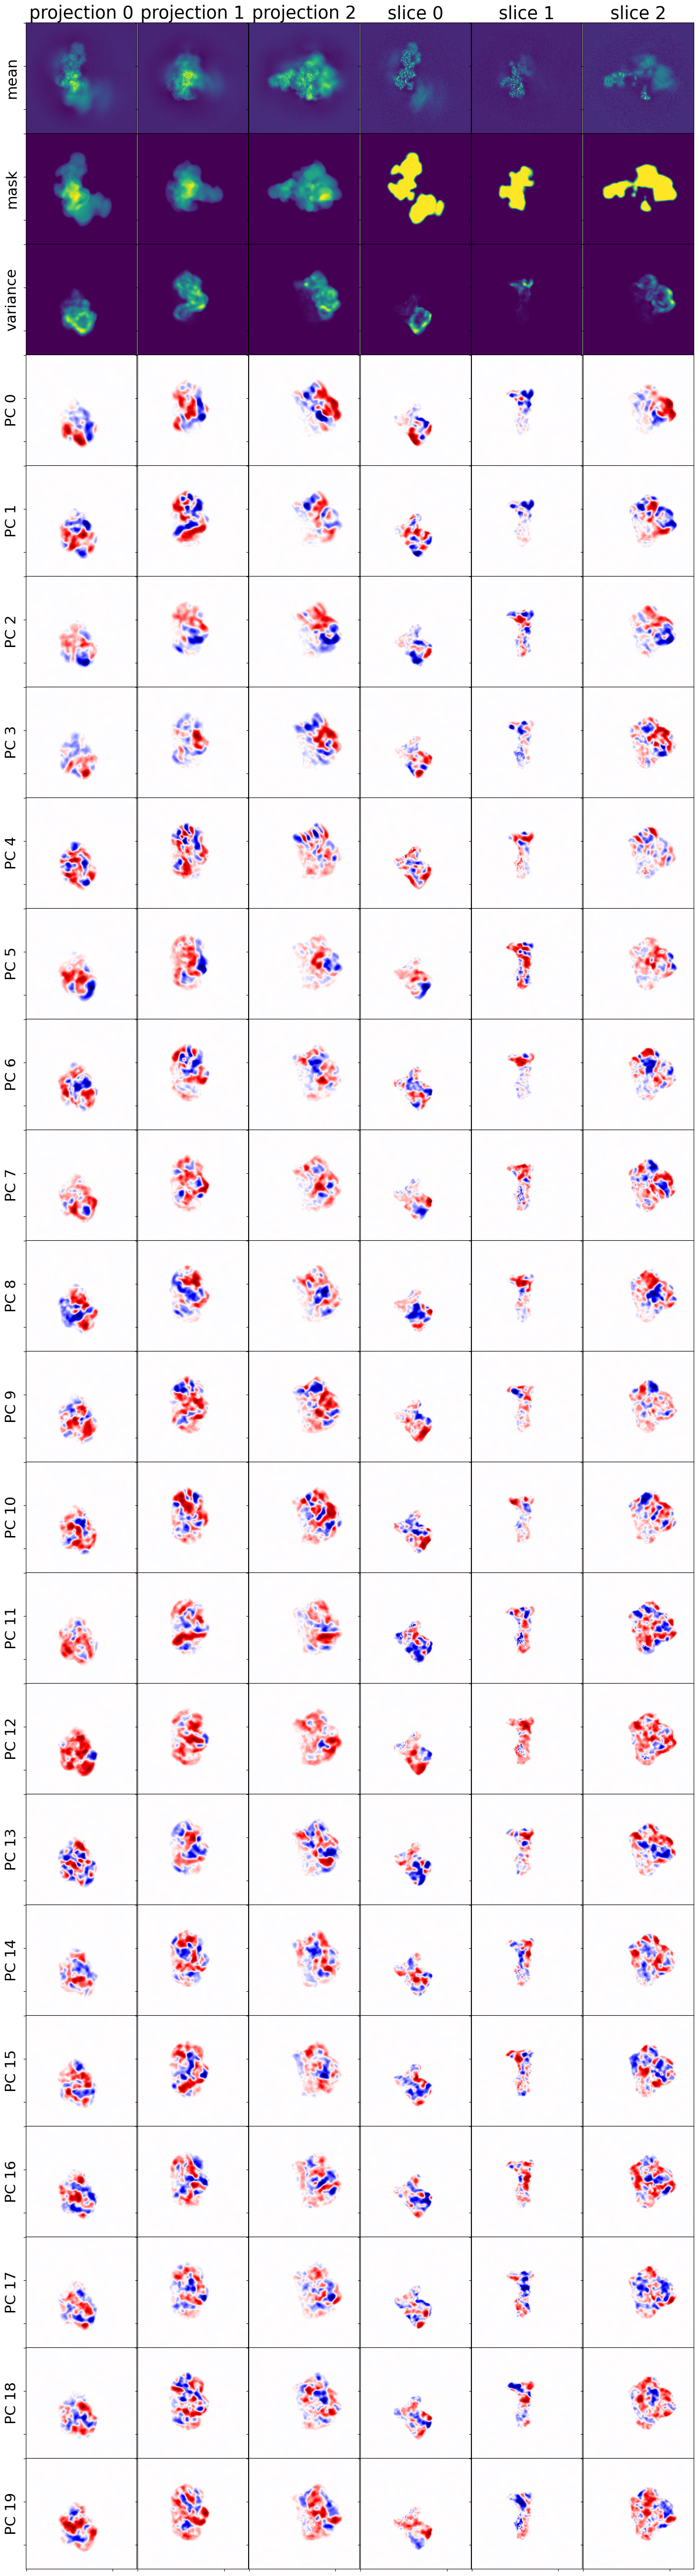

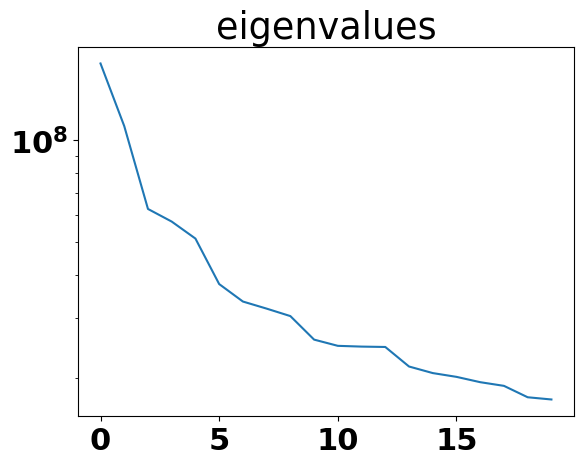

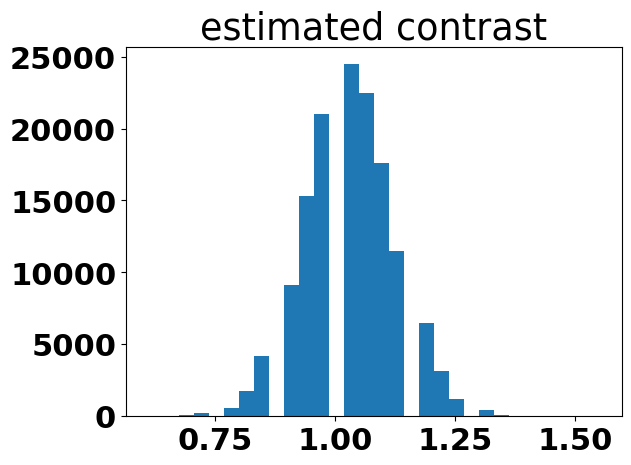

In [5]:
reload(plot_utils)
plot_utils.plot_summary_t(pipeline_output,cryos, n_eigs=20)
plt.figure();
plt.semilogy(pipeline_output.get('s')[:20])
plt.title('eigenvalues')
plt.figure()
plt.hist(pipeline_output.get('contrasts')[10], bins = 30)
plt.title('estimated contrast')
print(np.std(pipeline_output.get('contrasts')[10]))

(INFO) (latent_density.py) (18-Jun-24 17:15:51) latent space computation:, 33.69658160209656


2024-06-18 17:16:42.918191: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %pad.48 = f64[50,99,99,50]{3,2,1,0} pad(f64[50,99,50,50]{3,2,1,0} %constant.51, f64[] %broadcast.67), padding=0_0x0_0x0_49x0_0, metadata={op_name="jit(ridge_reg_objective_grid)/jit(main)/jvp(jit(ridge_reg_objective_grid))/jit(_pad)/pad[padding_config=((0, 0, 0), (0, 0, 0), (0, 49, 0), (0, 0, 0))]" source_file="/home/mg6942/recovar/recovar/deconvolve_density.py" source_line=335}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-06-18 17:16:43.395692: E external/xla/xla/service/slow_operation_alarm.cc:133] 

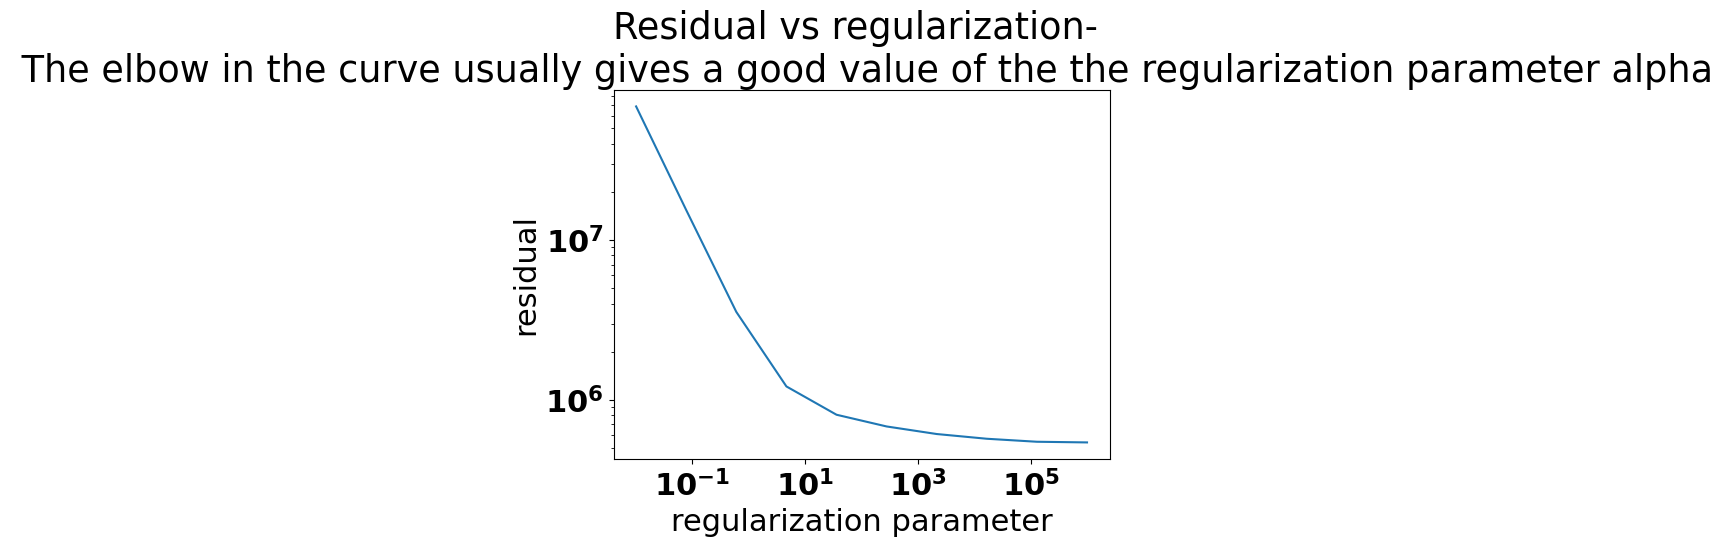

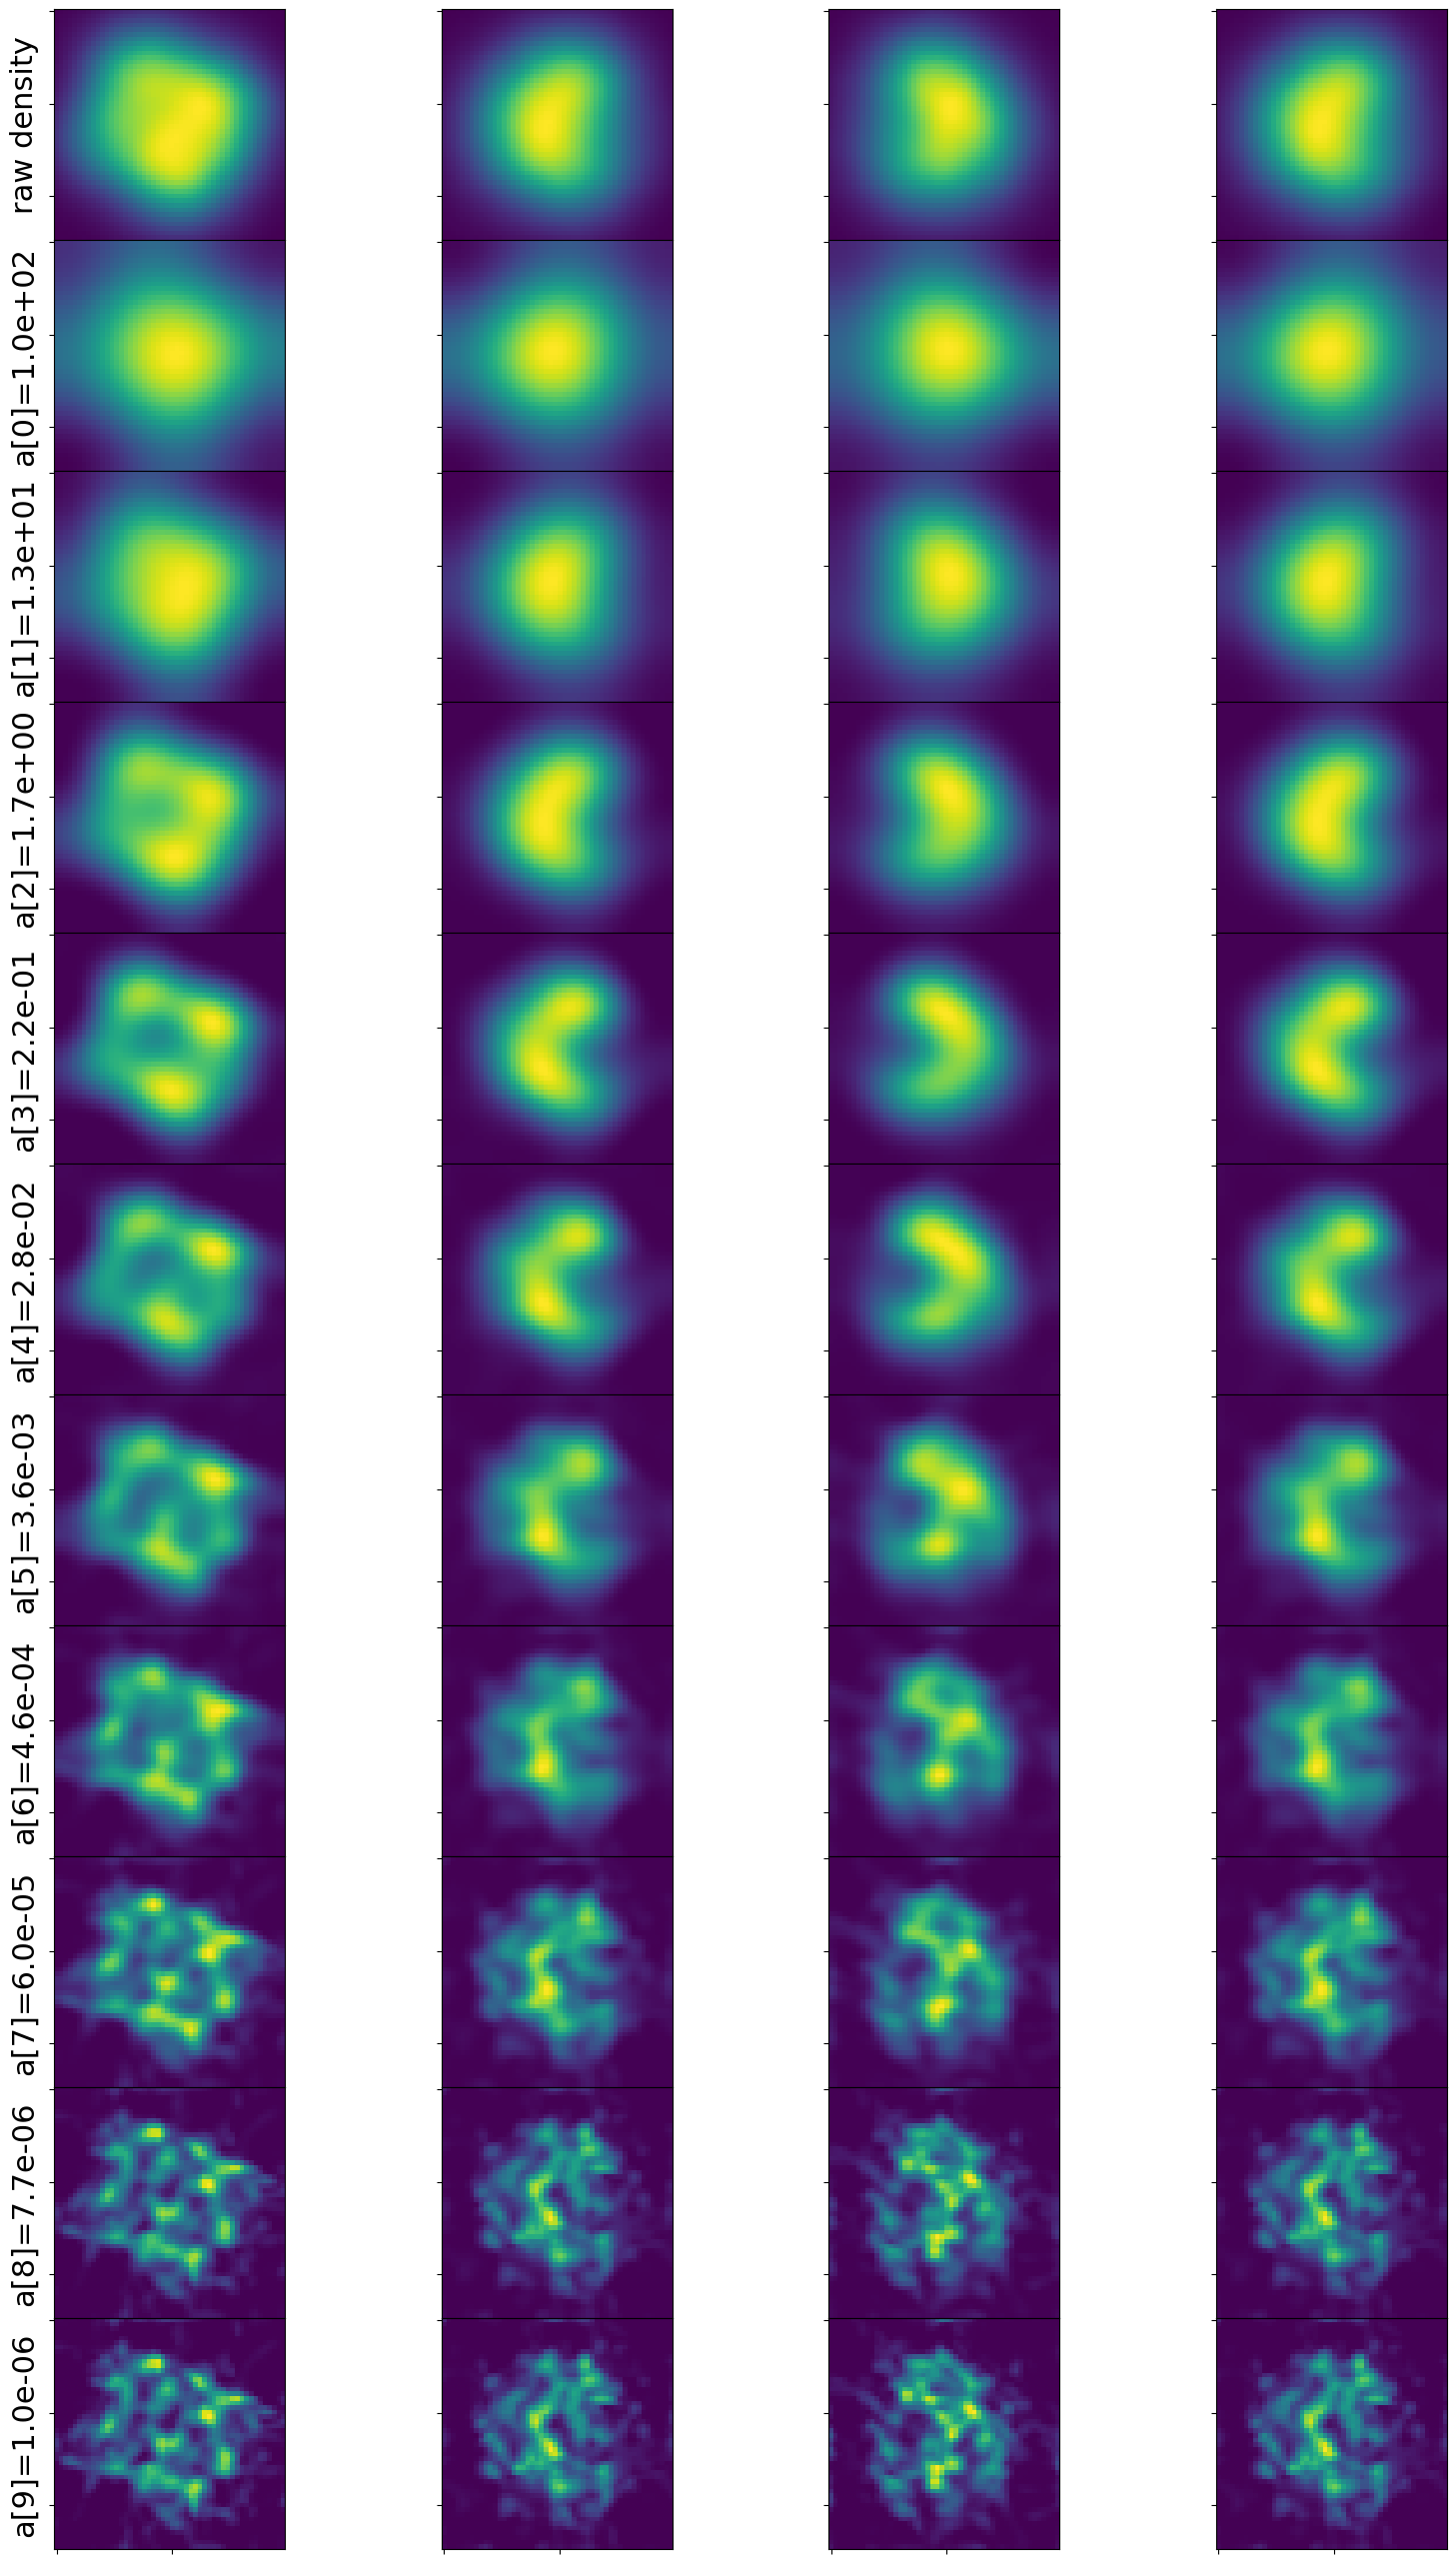

In [6]:
from recovar import deconvolve_density 
reload(deconvolve_density)
alphas = np.flip(np.logspace(-6, 2, 10))
percentile_reject = 10
zdim = '4_noreg'
lbfgsb_sols, alphas, cost, reg_cost, density, total_covar, grids, bounds = deconvolve_density.get_deconvolved_density(pipeline_output, zdim = zdim, pca_dim_max = 4, percentile_reject = percentile_reject, kernel_option = 'sampling', num_points = 50, alphas = alphas, percentile_bound=1)
plt.figure()
plt.loglog(1/alphas, cost)
plt.xlabel('1/(regularization parameter)')
plt.ylabel('residual')
plt.title('Residual vs regularization- \n The elbow in the curve usually gives a good value of the the regularization parameter alpha')

# Visualization of the result of deconvolution under different regularization
deconvolve_density.plot_density(lbfgsb_sols, density, alphas)

In [9]:
## Choose an index, and store the deconvolved density. You can then use it to generate trajectories with 
## python generate_trajectories.py ... --density [recovar_result_dir + 'deconv_density.pkl'] 
## See documentaiton
from recovar import utils
idx = 4
deconv_density =  lbfgsb_sols[idx]
# utils.pickle_dump({ 'density' : lbfgsb_sols[idx], 'latent_space_bounds' : bounds, 'alpha': alphas[idx] }, recovar_result_dir + 'deconv_density.pkl')

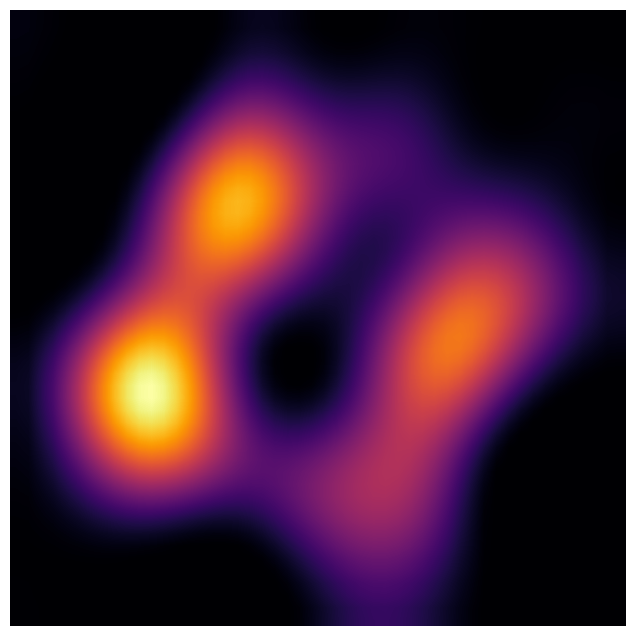

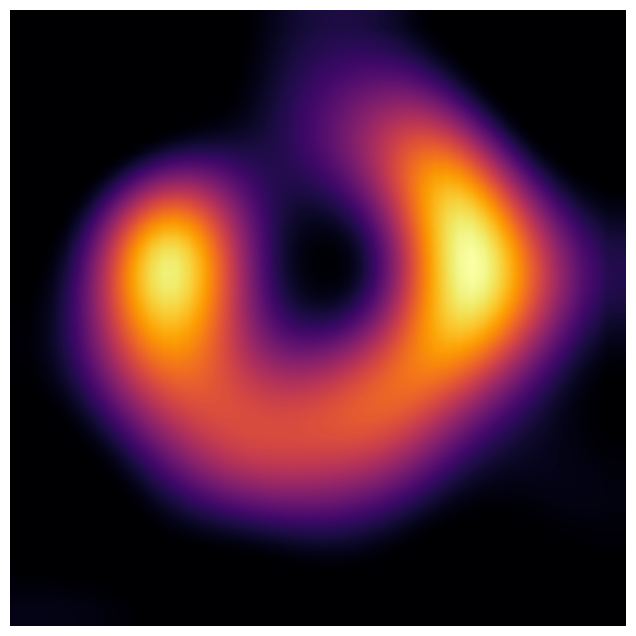

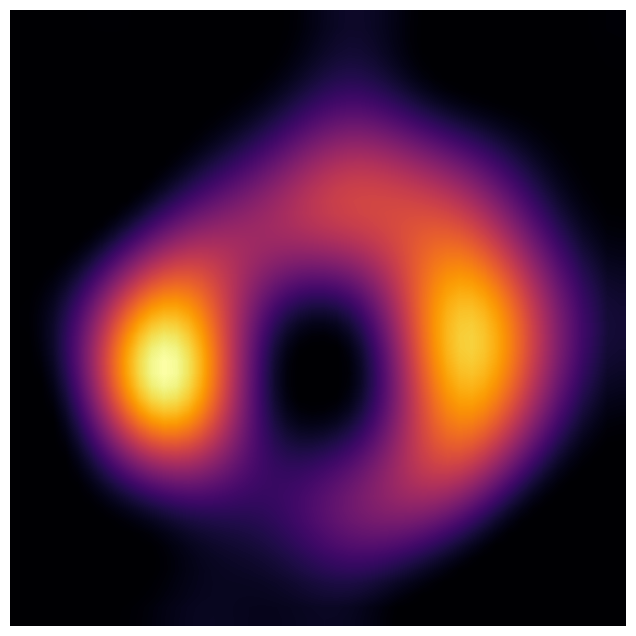

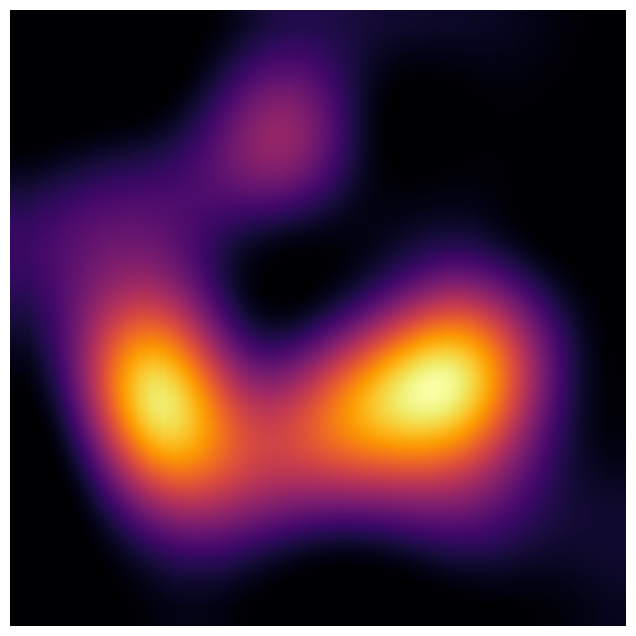

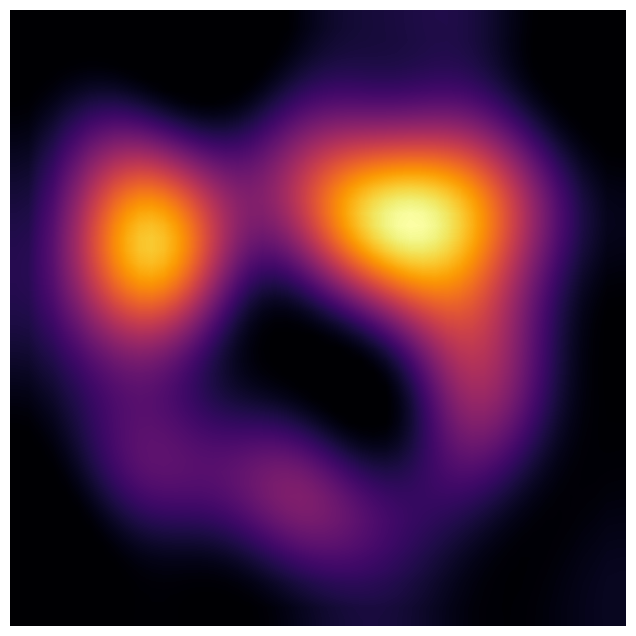

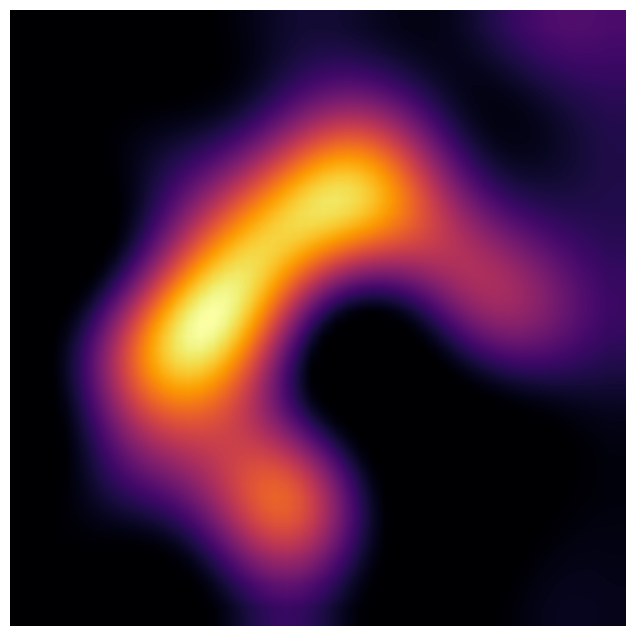

In [17]:
# Plot a density sliced in the middle of the distribution
output.plot_over_density(np.array(deconv_density), None, bounds, cmap = 'inferno',  projection_function = 'slice') 


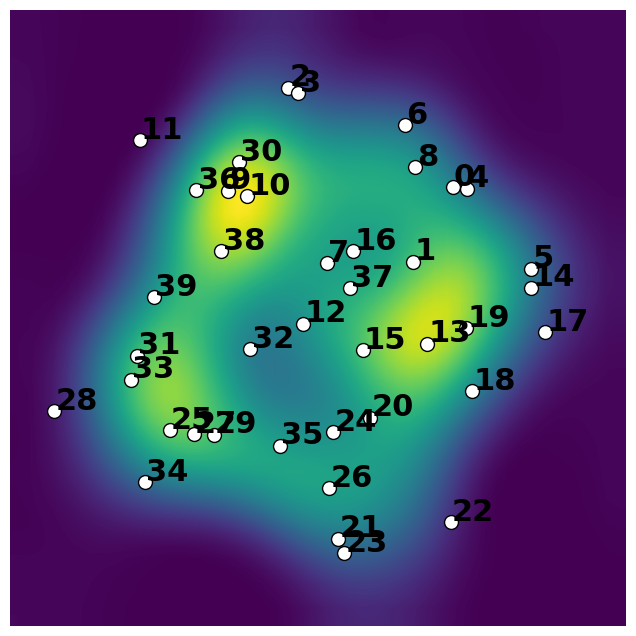

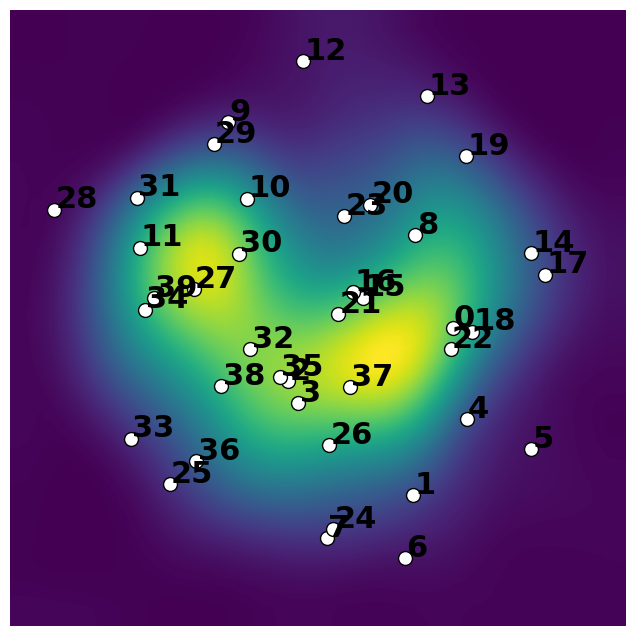

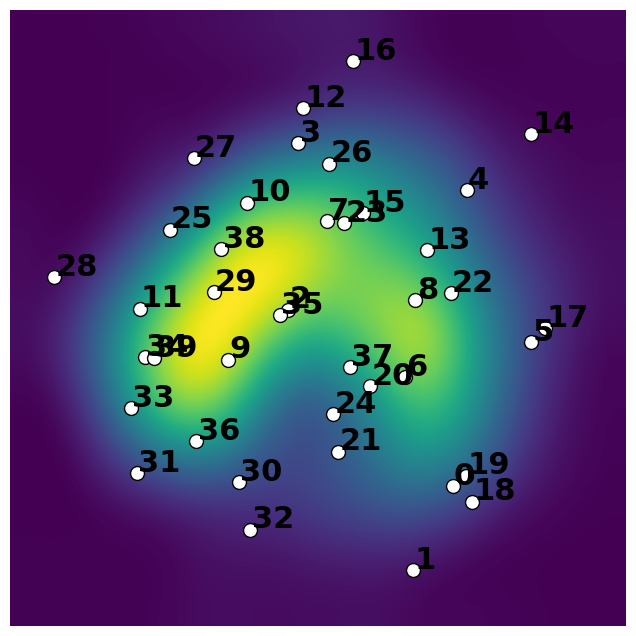

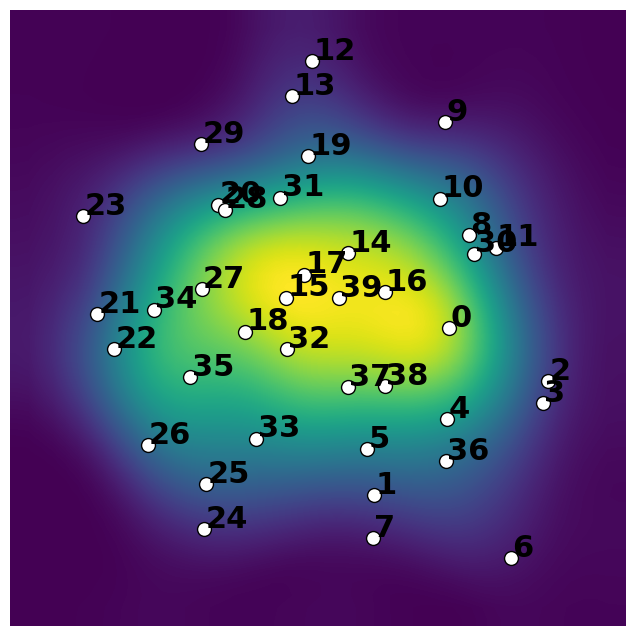

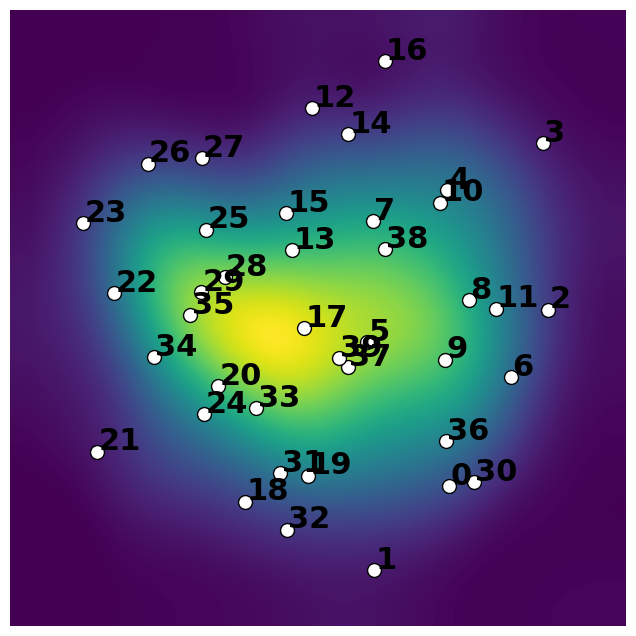

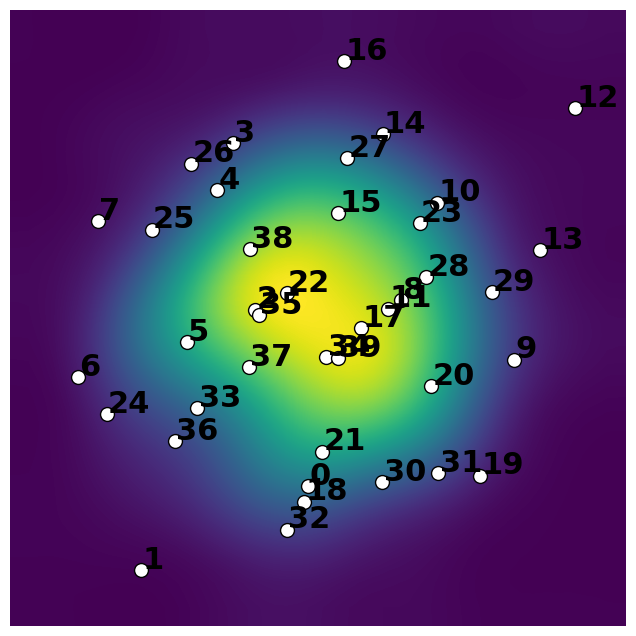

In [23]:
from recovar import latent_density
deconv_density =  lbfgsb_sols[idx]
output_dir = recovar_result_dir + 'output/analysis_4_noreg/'
centers = recovar.utils.pickle_load(output_dir + 'centers.pkl')['centers']
grid_to_z, z_to_grid = latent_density.get_grid_z_mappings(bounds, density.shape[0])
centers_grid = z_to_grid(centers)
output.plot_over_density(np.array(deconv_density), None, bounds, cmap = None, points = centers_grid, projection_function = None, annotate = True) 


(INFO) (output.py) (18-Jun-24 17:45:50) after path 12.947945356369019
(INFO) (output.py) (18-Jun-24 17:45:51) after all plots 0.3748171329498291


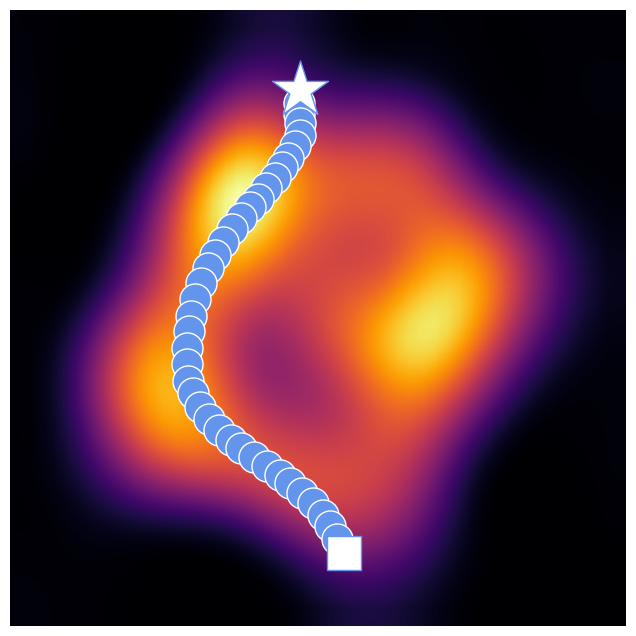

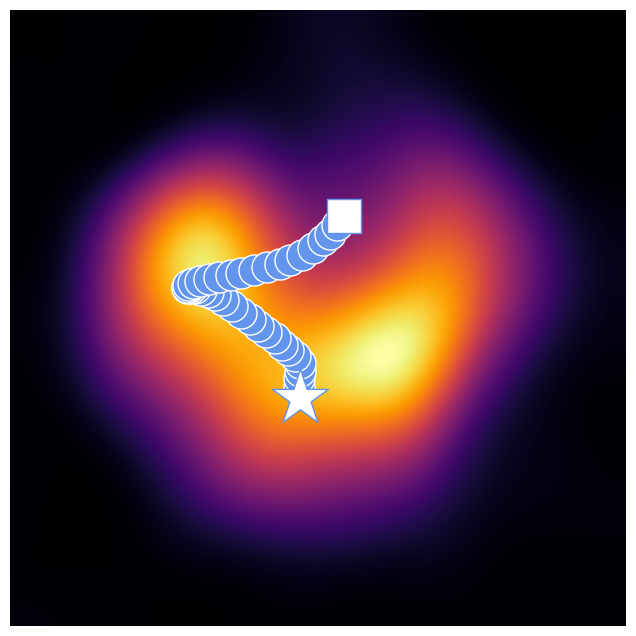

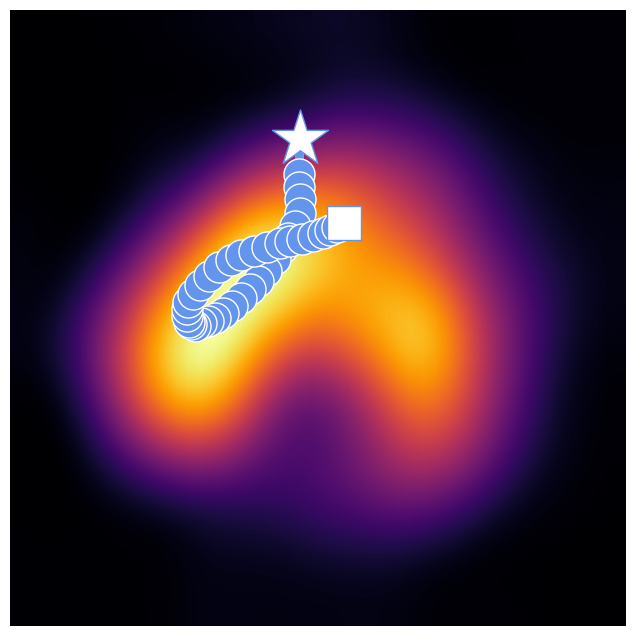

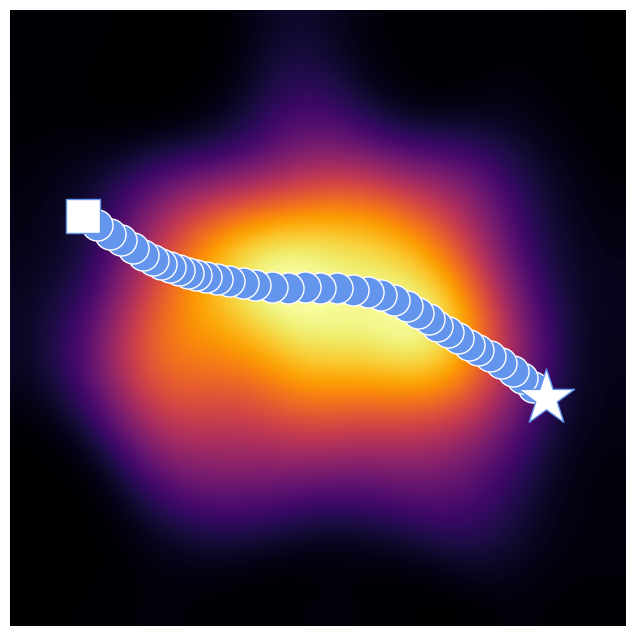

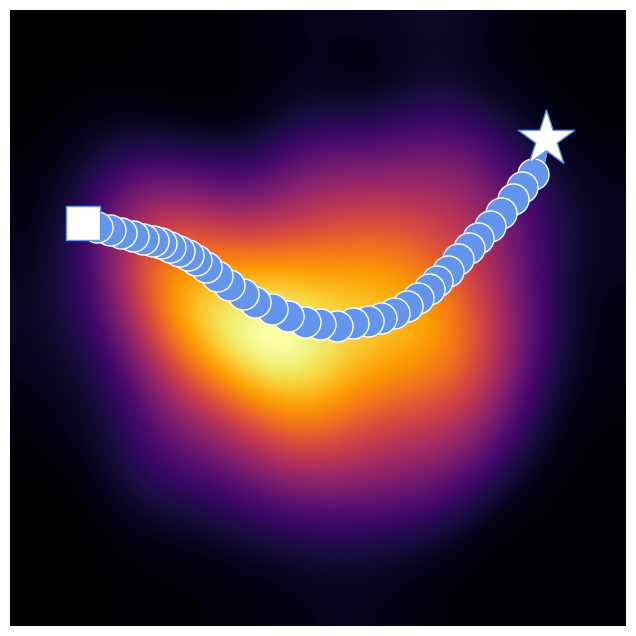

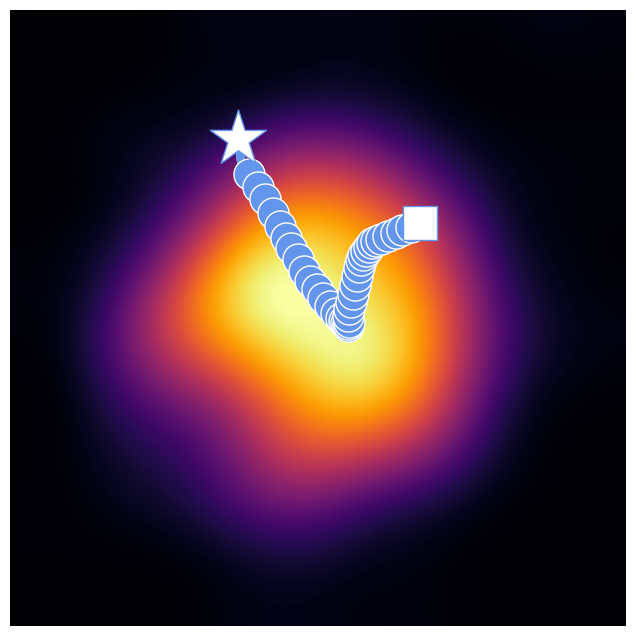

In [27]:
# Then you can visualize the trajectory between different kmeans
from recovar import output as o

z_st = centers[3]
z_end = centers[23]
from recovar import trajectory
full_path, subsampled_path = o.make_trajectory_plots_from_results(pipeline_output, 4, './path', cryos = cryos, z_st = z_st, z_end = z_end, gt_volumes= None, n_vols_along_path = 40, plot_llh = False, input_density = deconv_density, latent_space_bounds = bounds)


### Load result from analyze

In [31]:
zdim = '4_noreg'
analysis_dir = f'{recovar_result_dir}output/analysis_{zdim}'
centers = recovar.utils.pickle_load(f'{analysis_dir}/centers.pkl')

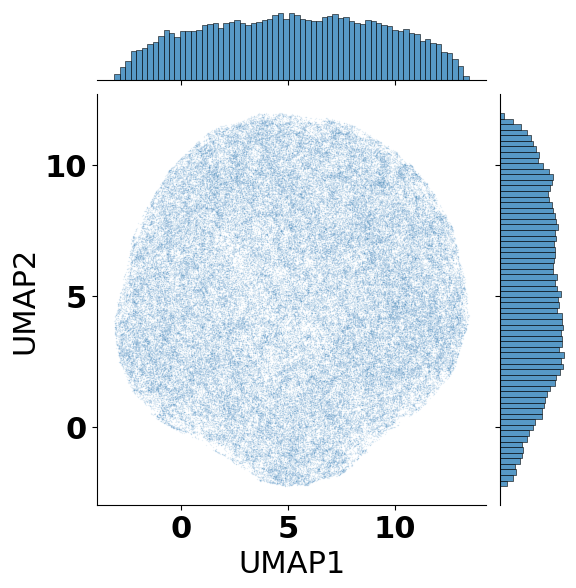

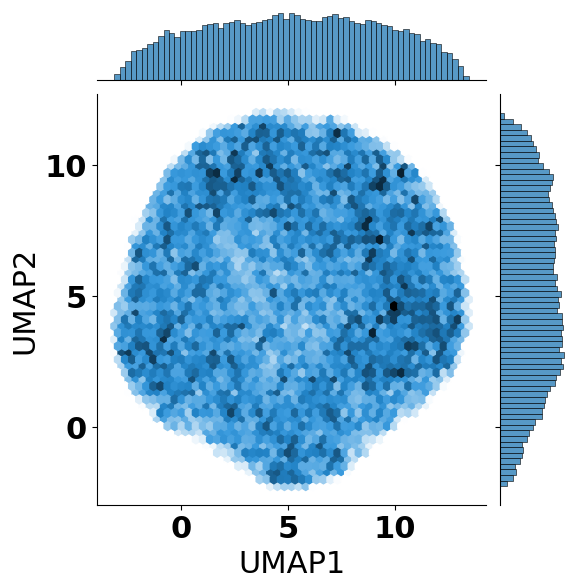

In [38]:
# If you changed the output dir, specify it here
# analysis_dir = f'{recovar_result_dir}output/analysis_{z_dim_used}'
# Load UMAP
umap = recovar.utils.pickle_load(f'{analysis_dir}/umap/embedding.pkl')
# or run UMAP
# z = pipeline_output.get('zs')[20]
# umap = analysis.run_umap(z)

g = sns.jointplot(x=umap[:,0], y=umap[:,1], alpha=.1, s=1)
g.set_axis_labels('UMAP1', 'UMAP2')
# plt.savefig('test' + 'centers_'+str(axes[0]) + str(axes[1])+'.png' )

g = sns.jointplot(x=umap[:,0], y=umap[:,1], kind='hex')
g.set_axis_labels('UMAP1', 'UMAP2')

In [43]:
# Load kmeans
K = 40
# kmeans_labels = utils.load_pkl(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/labels.pkl')
kmeans_results = recovar.utils.pickle_load(f'{analysis_dir}/centers.pkl')
kmeans_centers = kmeans_results['centers']
kmeans_labels = kmeans_results['labels']

# Or re-run kmeans with the desired number of classes
# kmeans_labels, kmeans_centers = analysis.cluster_kmeans(z, 20)

# # Get index for on-data cluster center
# kmeans_centers, centers_ind = analysis.get_nearest_point(z, kmeans_centers)

### PCA

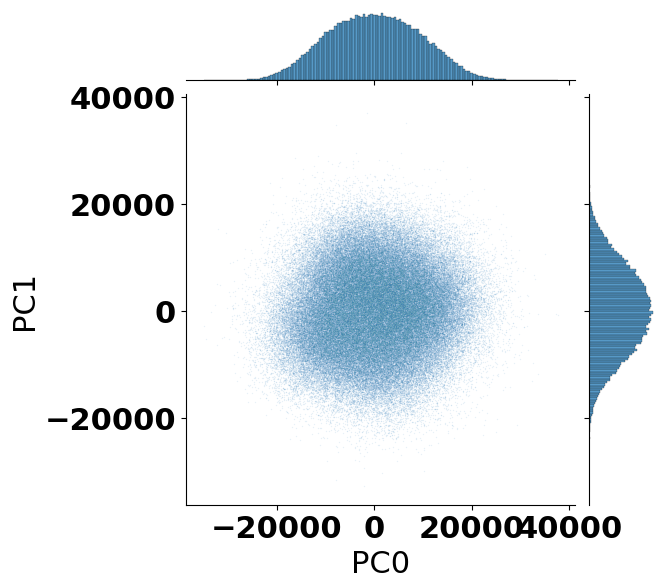

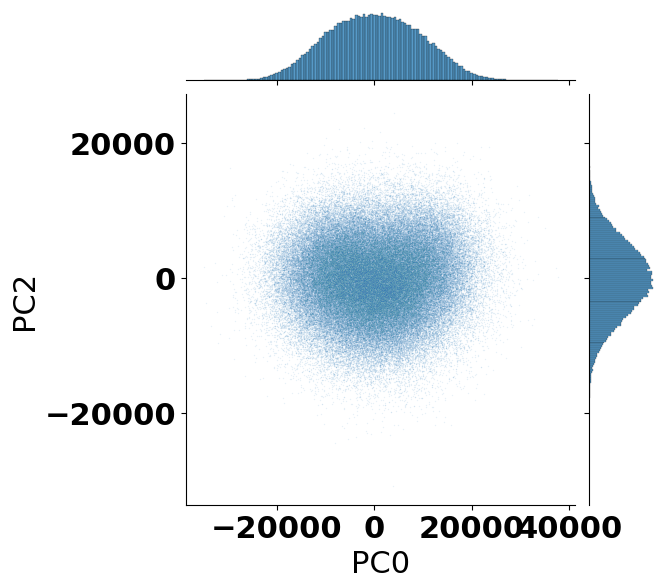

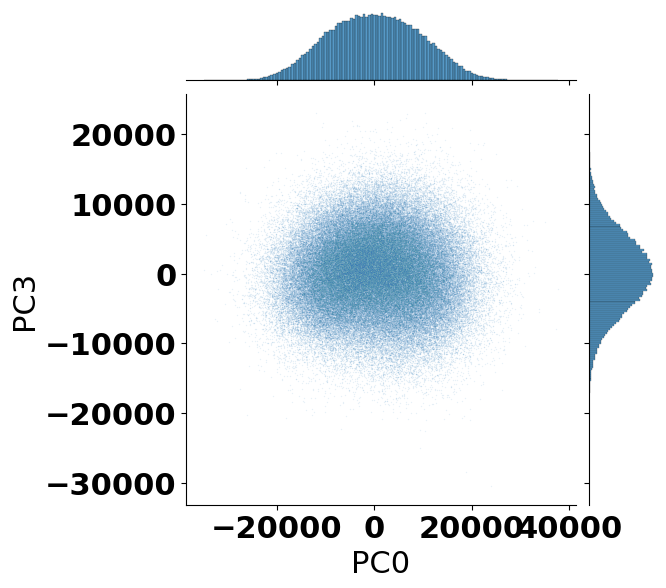

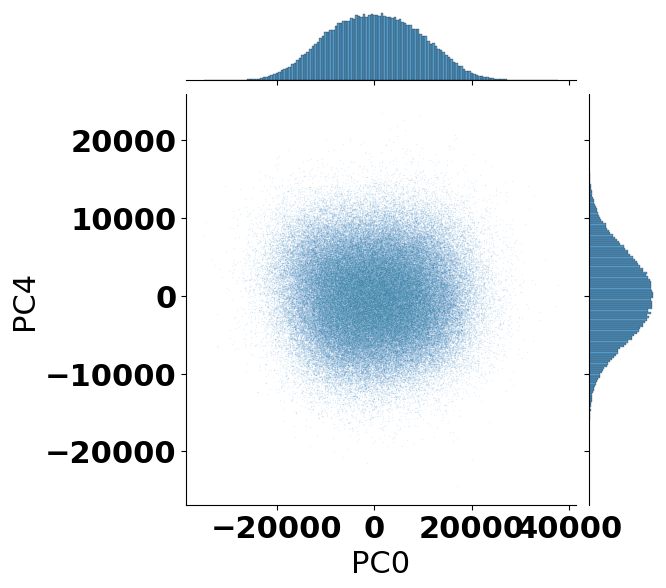

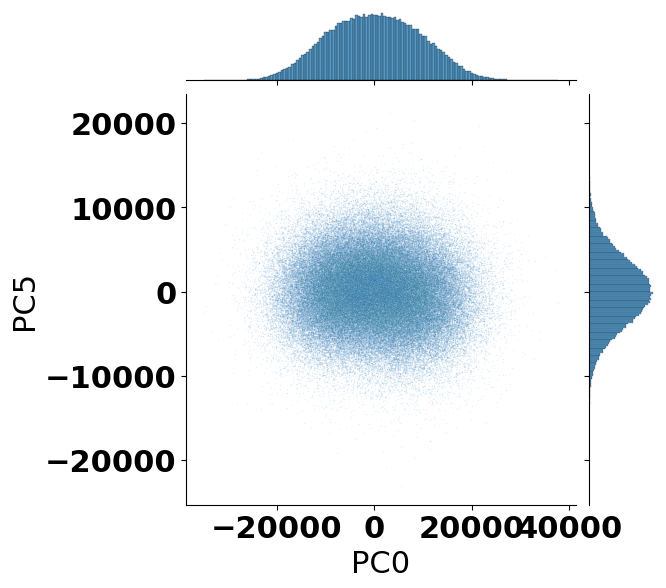

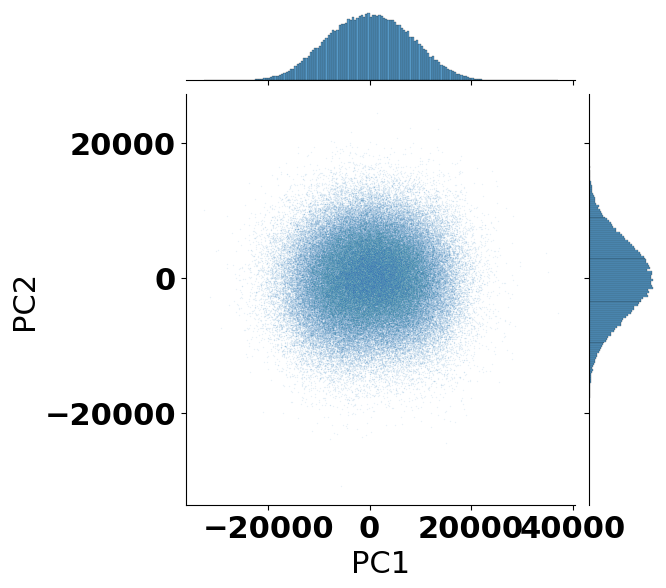

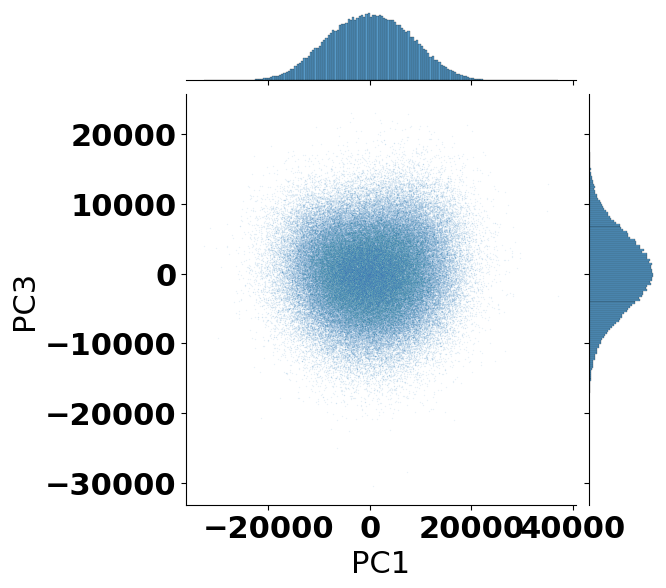

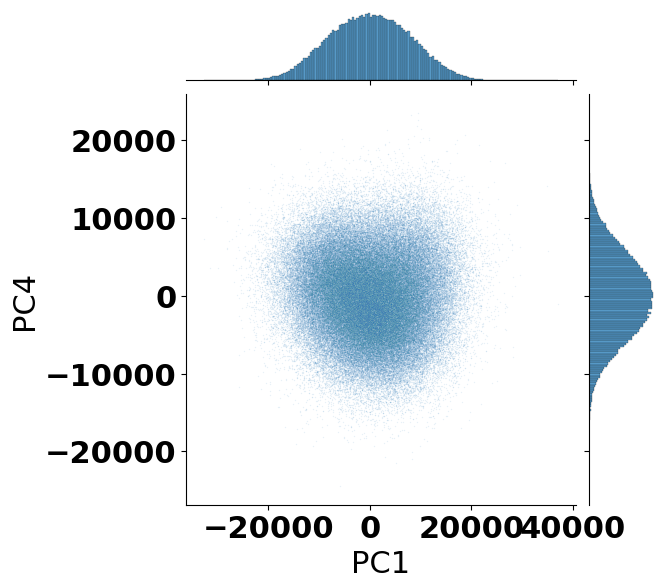

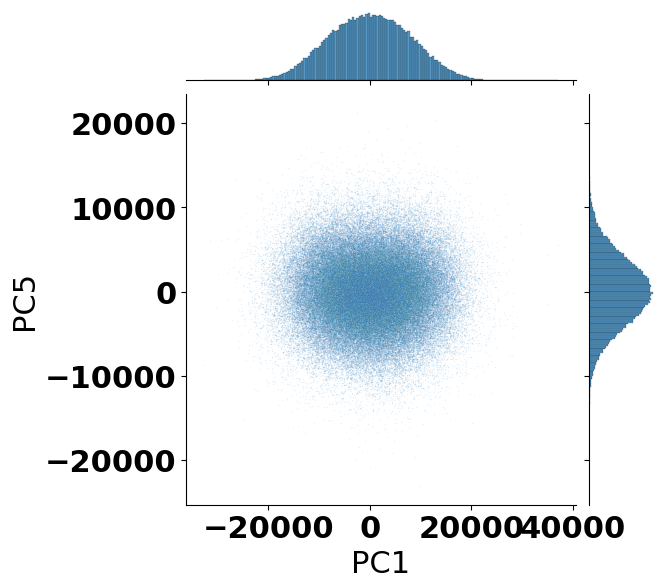

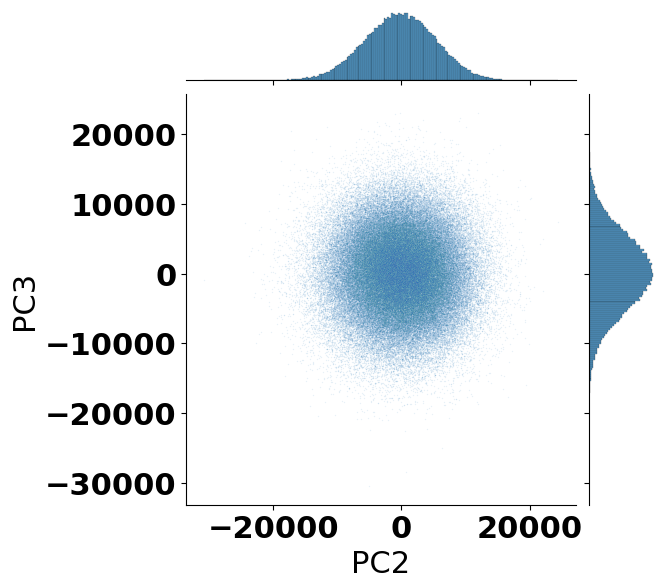

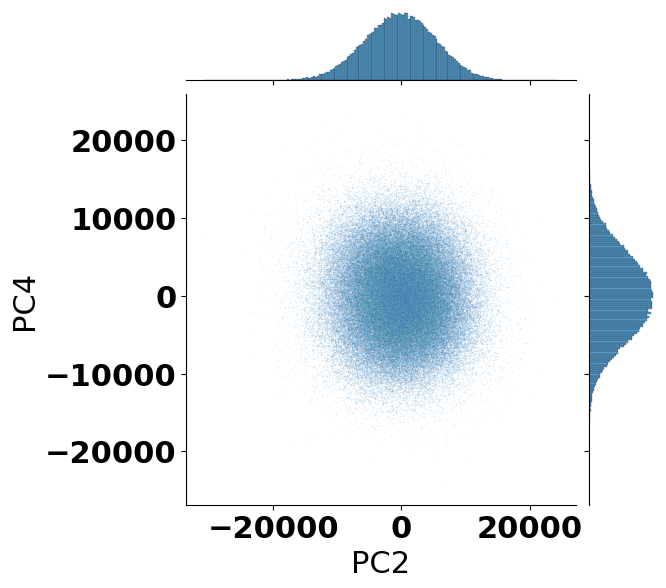

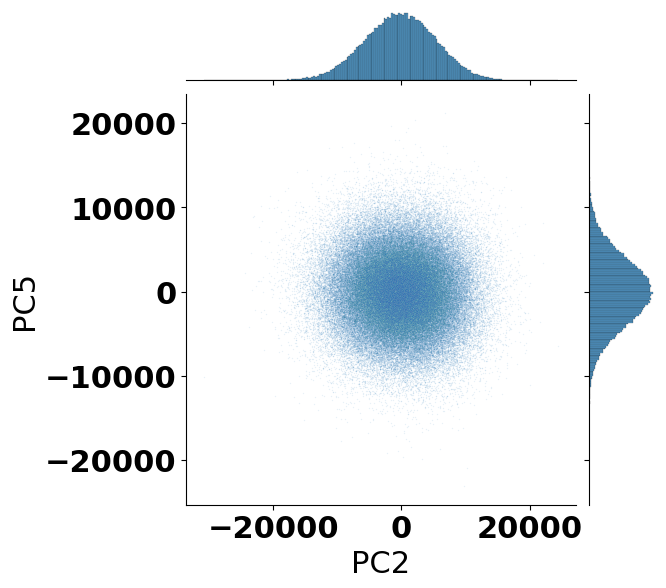

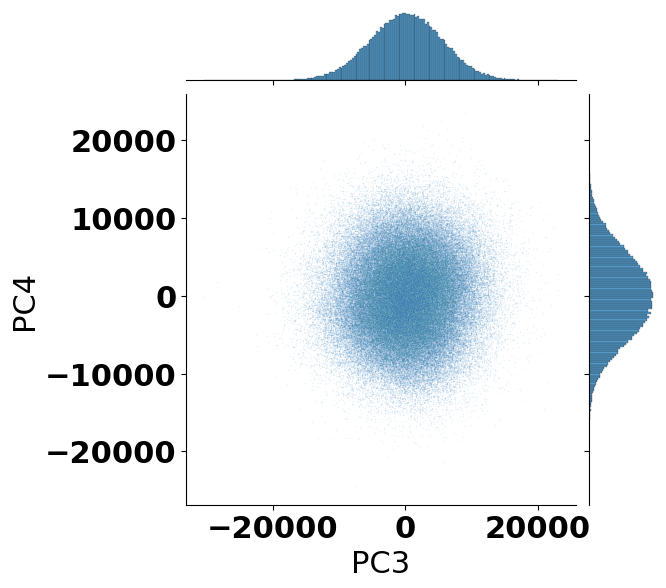

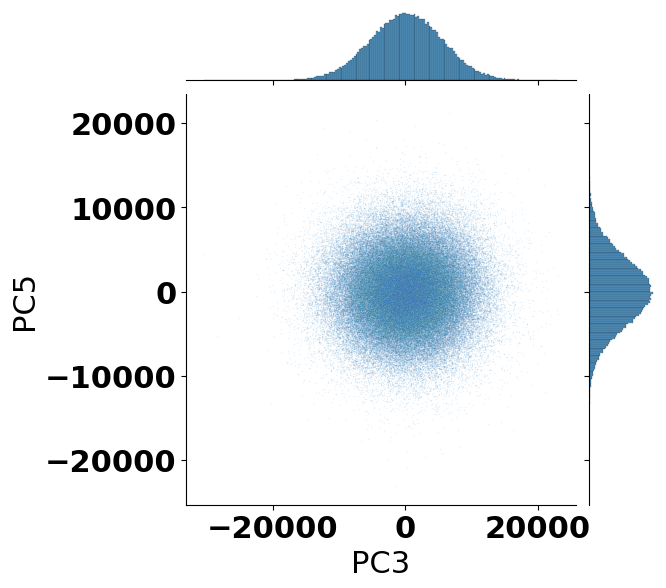

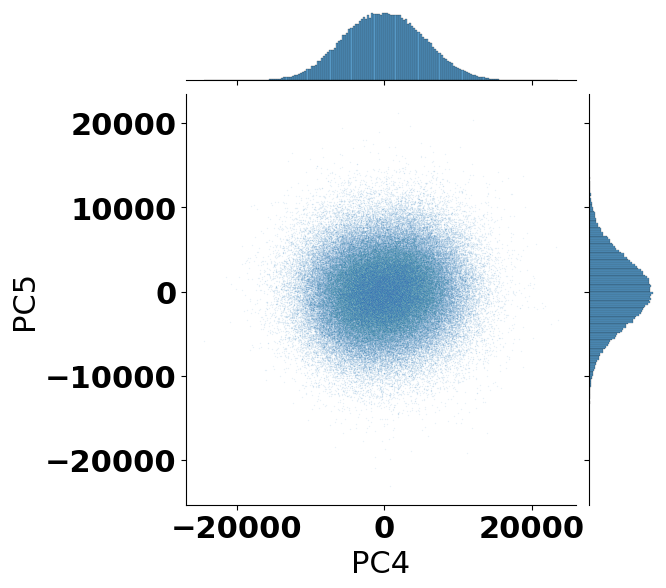

In [44]:
pc = z
for k1 in range(6):
    for k2 in range(k1+1,6):
        g = sns.jointplot(x=pc[:,k1], y=pc[:,k2], alpha=.1, s=1)
        g.set_axis_labels('PC'+str(k1), 'PC'+str(k2))